#Introduction

Remote sensing image data has been widely used in different fields in recent years. Satellite images are one of the major sources for remote sensing and they have been used in urban planning, disaster detection, tracking carbon emission etc.. Advanced AI and ML are definitely playing a critical role in identifying the images. 
The goal of this project is to test various models that can identify different types of buildings in the images. This dataset is a subset of the Satellite Remote Sensing Image RSI-CB256 dataset which was created to be used as a benchmark dataset for using ML in remote sensing image classification. This subset was taken from https://1drv.ms/u/s!Am218i8VSQEBaTyXDc-zA56zPv4
This dataset includes ~3.8k images and 4 classes. Images from the same class are stored in the same directory named as the class label. Image size is 256x256 for all.
- folder “city_building” : 1014 files
- folder “residents”:  810 files
- folder “storage_room”: 1307 files
- folder “container”: 660 files

####This notebook (01) loads the images and labels, and save them as tensorflow datasets that will be used in notebook 02 for modeling. Some functions called in this notebook and other notebooks are defined in 'mymodules.py' file.

In [1]:
#Import libraries
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
print("TF version:", tf.__version__)

#Check whether GPU is available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.9.2
GPU not available


Link to Google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the user defined modules

In [3]:
import sys
sys.path.append('./drive/MyDrive/satellite_images_classification/notebooks')
import mymodules

#1. Load and process data

In [4]:
DATA_PATH = "./drive/MyDrive/satellite_images_classification/construction_land_data"
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [5]:
unique_labels = []
for folders in os.listdir(DATA_PATH):
    unique_labels.append(folders)
print("There are {} classes: {}".format(len(unique_labels), unique_labels))

There are 4 classes: ['city_building', 'container', 'residents', 'storage_room']


##1.1 Load images

Load in the images from each folder, and plot the count of images in each class

In [6]:
image_names_arr, labels_arr = mymodules.retrieve_images_and_labels(DATA_PATH, unique_labels)
print("The total number of images is", len(image_names_arr))

The total number of images is 3791


[1014, 660, 810, 1307]


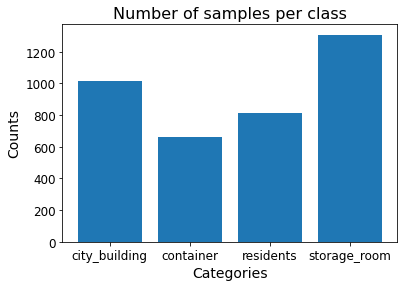

In [7]:
mymodules.plot_image_counts(unique_labels, labels_arr)

##1.2 Split dataset and prepare datasets for modeling

In [8]:
# split into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(image_names_arr, labels_arr, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

load in the images, scale, resize

In [9]:
train_ds = mymodules.get_dataset(X_train, y_train)
valid_ds = mymodules.get_dataset(X_valid, y_valid)
test_ds = mymodules.get_dataset(X_test, y_test)

In [10]:
print('training set: {} \nvalidation set: {} \ntest set: {}'.format(len(train_ds), len(valid_ds), len(test_ds)))

training set: 2425 
validation set: 607 
test set: 759


shuff, batch, prefetch

In [11]:
train_ds = train_ds.shuffle(buffer_size=200).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##1.3 Display the images in the first batch

In [12]:
img, lbl = next(train_ds.as_numpy_iterator())
len(img), len(lbl)

(32, 32)

In [13]:
unique_labels_arr = np.array(unique_labels)

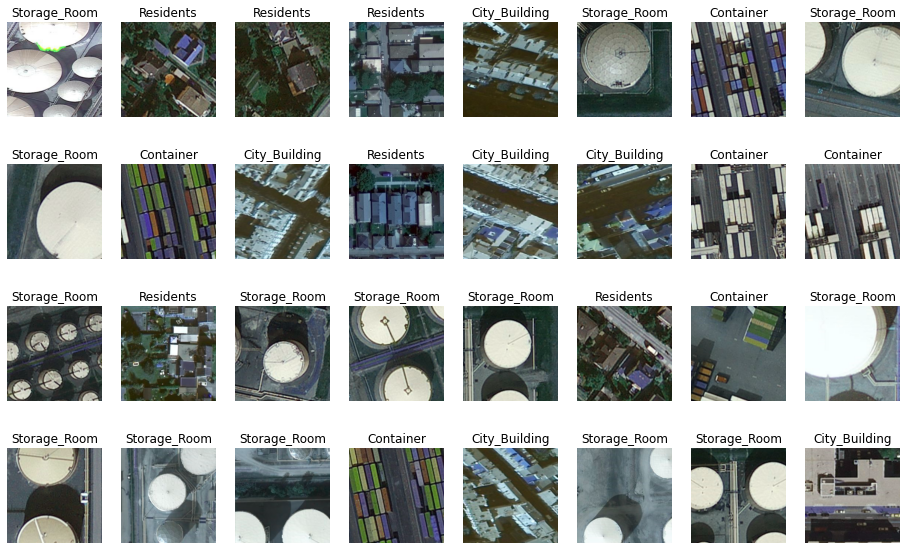

In [14]:
fig, axes = plt.subplots(4, 8, figsize=(16,10))
for i, ax in enumerate(axes.flat):
  ax.imshow(img[i])
  ax.axis('off')
  ax.set_title(unique_labels_arr[lbl[i]].title(), fontsize=12)

##1.4 Save the tensorflow datasets for training, validation and test sets.

These datasets are used in notebook 02 for modeling

In [15]:
OUTPUT_PATH = "./drive/MyDrive/satellite_images_classification/saved_tf_datasets/"
tf.data.experimental.save(train_ds, OUTPUT_PATH + 'train_ds')
tf.data.experimental.save(valid_ds, OUTPUT_PATH + 'valid_ds')
tf.data.experimental.save(test_ds, OUTPUT_PATH + 'test_ds')